# Homework 02: Probability Theory and Density Estimation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np
import pandas as pd
import os.path
import subprocess
import scipy.stats
from sklearn import neighbors, cluster

Helpers for Getting, Loading and Locating Data

In [2]:
def wget_data(url: str):
    local_path = './tmp_data'
    p = subprocess.Popen(["wget", "-nc", "-P", local_path, url], stderr=subprocess.PIPE, encoding='UTF-8')
    rc = None
    while rc is None:
      line = p.stderr.readline().strip('\n')
      if len(line) > 0:
        print(line)
      rc = p.poll()

def locate_data(name, check_exists=True):
    local_path='./tmp_data'
    path = os.path.join(local_path, name)
    if check_exists and not os.path.exists(path):
        raise RuxntimeError('No such data file: {}'.format(path))
    return path

## <span style="color:Orange">Problem 1</span>

Implement the function below to calculate the event probabilities $P(A)$, $P(B)$, $P(A \cap B)$ and the conditional probabilities $P(A\mid B)$, $P(B\mid A)$ for an arbitrary (finite) probability space specified by each outcome's probability. *Hint: the probability of an event containing a set of outcomes is just the sum of the individual outcome probabilities.*

In [3]:
np.array([4,5,2,1]) * np.array([0,1,0,1])

array([0, 5, 0, 1])

In [9]:
def calculate_probabilities(p, A, B):
    """Calculate probabilities for an arbitrary probability space.

    Parameters
    ----------
    p : float array of shape (N,)
        Probabilities for each of the N possible outcomes in the probability space.
    A : boolean array of shape (N,)
        Identifies members of event set A in the probability space.
    B : boolean array of shape (N,)
        Identifies members of event set B in the probability space.

    Returns
    -------
    tuple
        Tuple of five probabilities values:
        P(A), P(B), P(A instersect B), P(A | B), P(B | A).
    """
    assert np.all((p >= 0) & (p <= 1))
    assert np.sum(p) == 1

    # YOUR CODE HERE
    return (np.sum(p * A), np.sum(p * B), np.sum(p*(A*B)), np.sum(p*(A*B))/np.sum(p * B), np.sum(p*(A*B))/np.sum(p * A))

In [10]:
# A correction solution should pass the tests below.
gen = np.random.RandomState(seed=123)
N = 100
p = gen.uniform(size=(4, N))
p = (p / p.sum(axis=1).reshape(-1, 1)).reshape(-1) / 4.

# Test when A and B are "independent" events, i.e., P(A interset B) = P(A) P(B).
A = np.arange(4 * N) < 2 * N
B = (np.arange(4 * N) >= N) & (np.arange(4 * N) < 3 * N)
print(calculate_probabilities(p, A, B), 3)
assert np.allclose(
    np.round(calculate_probabilities(p, A, B), 3),
    [0.5, 0.5, 0.25, 0.5, 0.5])

# Test with randomly generated events A, B.
A = gen.uniform(size=4*N) < 0.3
B = gen.uniform(size=4*N) > 0.6
#print(np.round(event_probabilities(p, A, B), 3))
assert np.allclose(
    np.round(calculate_probabilities(p, A, B), 3),
    [0.278, 0.33, 0.076, 0.23, 0.273])

(np.float64(0.5), np.float64(0.5), np.float64(0.25), np.float64(0.5), np.float64(0.5)) 3


## <span style="color:Orange">Problem 2</span>

The cumulative distribution function (CDF) is the fundamental representation of a random variable, rather than the probability density function (PDF) which might not be defined, is not a probability and generally has dimensions. In this problem, you will explore a practical application of the CDF for generating random numbers.

Since the CDF $y = F_X(x)$ maps from random variable values to the range $[0,1]$, its inverse $x = F_X^{-1}(y)$ maps from $[0,1]$ back to the random variable. What distribution of $y$ values would generate values according to the PDF $f_X(x)$ when transformed by the inverse $F_X^{-1}(y)$? The answer is a uniform distribution, as we can demonstrate numerically for an arbitrary random variable:

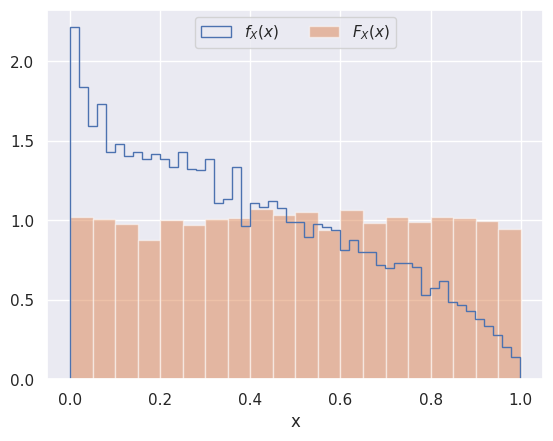

In [45]:
def cdf_hist(X, n=10000, seed=123):
    gen = np.random.RandomState(seed=seed)
    # Generate n random value from the scipy.stats distribution X.
    x = X.rvs(n, random_state=gen)
    plt.hist(x, bins=50, label='$f_X(x)$', histtype='step', lw=2, density=True)
    # Histogram the corresponding CDF values.
    y = X.cdf(x)
    plt.hist(y, bins=20, label='$F_X(x)$', alpha=0.5, density=True)
    plt.xlabel('x')
    plt.legend(loc='upper center', ncol=2)

cdf_hist(scipy.stats.beta(0.9, 1.5))

When the function $F_X(x)$ can be inverted analytically, you can use it to transform uniformly generated random values into a random sampling of the PDF $f_X(x)$.

For example, consider random outcomes consisting of $(x,y)$ points uniformly distributed on the disk,

$$ \Large
0 \le r_1 \le \sqrt{x^2 + y^2} \le r_2 \; .
$$

The CDF of the random variable $r \equiv \sqrt{x^2 + y^2}$ is then

$$ \Large
F_R(r) = \begin{cases}
1 & r > r_2 \\
\frac{r^2 - r_1^2}{r_2^2 - r_1^2} & r_1 \le r \le r_2 \\
0 & r < r_1
\end{cases}\; .
$$

Implement the function below to apply $F_R^{-1}(y)$ to uniformly distributed random values in order to sample $f_R(x)$:

In [60]:
def sample_disk(r1, r2, n, gen):
    """Sample random radii for points uniformly distributed on a disk.

    Parameters
    ----------
    r1 : float
        Inner radius of disk.
    r2 : float
        Outer radius of disk.
    n : int
        Number of random samples to generate.
    gen : np.random.RandomState
        Random state for reproducible random numbers.
        Uses gen.uniform() internally, not gen.rand().

    Returns
    -------
    array
        Array of n randomly generated r values.
    """
    assert (r1 >= 0) and (r1 < r2)

    # YOUR CODE HERE
    Y = scipy.stats.uniform(r1,r2-r1)
    x = np.sqrt((np.ones(n)*r2**2 - np.ones(n)*r1**2)+np.ones(n)*r1**2)

    return x

In [61]:
# A correct solution should pass these tests.
r1, r2, n = 1., 2., 1000
gen = np.random.RandomState(seed=123)
r = sample_disk(r1, r2, n, gen)
assert np.all((r >= r1) & (r <= r2))
assert np.allclose(np.round(np.mean(r), 3), 1.556)
assert np.allclose(np.round(np.std(r), 3), 0.279)

r1, r2, n = 0., 2., 1000
r = sample_disk(r1, r2, n, gen)
assert np.all((r >= r1) & (r <= r2))
assert np.allclose(np.round(np.mean(r), 3), 1.325)
assert np.allclose(np.round(np.std(r), 3), 0.494)

AssertionError: 

Test your implementation by plotting some $(x,y)$ points with uniformly random $0 \le \theta < 2\pi$:

In [ ]:
gen = np.random.RandomState(seed=123)
r = sample_disk(0.8, 1.2, 1000, gen)
theta = gen.uniform(0, 2 * np.pi, size=len(r))
plt.scatter(r * np.cos(theta), r * np.sin(theta), s=5)
plt.gca().set_aspect(1)

Sometimes $F_X(x)$ cannot be inverted explicitly, either because the inverse has no closed form or because the underlying distribution is arbitrary.  In these cases, we can still apply the same method numerically.

Implement the function below to tabulate an empirical estimate of the CDF for an arbitrary random variable, as:

$$ \Large
x_{CDF} = x_{\text{lo}}, x_0, x_1, \ldots, x_{N-1}, x_{\text{hi}} \; ,
$$

where the $x_i$ are [sorted](https://docs.scipy.org/doc/numpy/reference/generated/numpy.interp.html), $x_0 \le x_1 \le \ldots \le x_{N-1}$, and corresponding CDF values:

$$ \Large
y_{CDF} = 0, \frac{1}{N+1}, \frac{2}{N+1}, \ldots, \frac{N}{N+1}, 1 \; .
$$

In [ ]:
def empirical_cdf(x, xlo, xhi):
    """Tabulate the empirical CDF from samples of an arbitrary random variable.

    Parameters
    ----------
    x : array of shape (N,)
        Array of input random variable values to use.
    xlo : float
        Low limit for the random variable x.
    xhi : float
        High limit for the random variable x.

    Returns
    -------
    tuple
        Tuple (x_cdf, y_cdf) of arrays both of shape (N+2,), padded at each end
        as described above.
    """
    assert xlo < xhi
    x = np.asarray(x)
    assert np.all((x >= xlo) & (x <= xhi))

    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
# A correct solution should pass these tests.
x_cdf, y_cdf = empirical_cdf([1, 2, 3, 4], 0, 5)
assert np.array_equal(x_cdf, [0, 1, 2, 3, 4, 5])
assert np.allclose(y_cdf, [0., .2, .4, .6, .8, 1.])

x_cdf, y_cdf = empirical_cdf([4, 2, 1, 3], 0, 5)
assert np.array_equal(x_cdf, [0, 1, 2, 3, 4, 5])
assert np.allclose(y_cdf, [0., .2, .4, .6, .8, 1.])

gen = np.random.RandomState(seed=123)
x = scipy.stats.beta(0.9, 1.5).rvs(size=4, random_state=gen)
x_cdf, y_cdf = empirical_cdf(x, 0., 1.)
assert np.allclose(
    np.round(x_cdf, 3),
    [ 0.   ,  0.087,  0.152,  0.42 ,  0.721,  1.   ])
assert np.allclose(y_cdf, [0., .2, .4, .6, .8, 1.])

Test your implementation by generating CDF samples matched to an unknown distribution.  Note that we use [linear interpolation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.interp.html) to numerically invert the empirical CDF in this approach, which is a useful trick to remember:

In [ ]:
n = 5000
gen = np.random.RandomState(seed=123)
X = scipy.stats.beta(0.9, 1.5)
# Generate samples using scipy.stats
x_in = X.rvs(n, random_state=gen)
plt.hist(x_in, bins=50, label='Input data', alpha=0.5, density=True)
# Generate samples using the empirical CDF of x_in
x_cdf, y_cdf = empirical_cdf(x_in, 0., 1.)
y = gen.uniform(size=n)
x = np.interp(y, y_cdf, x_cdf)
plt.hist(x, bins=50, label='CDF samples', histtype='step', lw=2, density=True)
plt.legend();

## <span style="color:Orange">Problem 3</span>

Consider a sequence of $n$ Bernoulli trials with success probabilty $p$ per trial. A string of consecutive successes is known as a success run. Write a function that returns the counts for runs of length $k$ for each $k$ observed in a python dictionary.

For example: if the trials were `[0, 1, 0, 1, 1, 0, 0, 0, 0, 1]`, the function should return `{1: 2, 2: 1}`

In [105]:
np.diff(np.array([1,1,1,0,0,1,0,1,1]))

array([ 0,  0, -1,  0,  1, -1,  1,  0])

In [102]:
from collections import Counter

def count_runs(xs):
    """Count number of success runs of length k.

    Parameters
    ----------
    xs : array of shape (1, nx)
        Vector of Bernoulli trials

    Returns
    -------
    dict
        Returns a dictionary the counts (val) for runs of length k (key) for each k observed
    """
    counts = {}
    # YOUR CODE HERE

    return counts

In [103]:
cnt = count_runs([0, 1, 0, 1, 1, 0, 0, 0, 0, 1],)
print(cnt)
assert [cnt[1],cnt[2]] == [2,1]

cnt = count_runs([0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1],)
assert [cnt[1],cnt[2],cnt[3]] == [1,1,1]

rng = np.random.default_rng(seed=1234)
cnt = count_runs(rng.integers(2,size=1000))
assert [cnt[1],cnt[2],cnt[3],cnt[4],cnt[5],cnt[6],cnt[7],cnt[8],cnt[9]] == [127,60,26,24,6,4,1,1,1]

{1: 1, 2: 1}


AssertionError: 

Using `count_runs` above, write a method `run_prob` that returns the probability of observing at least one run of length `k` or more from `n` trials with success probabilty `p` per trial. This probability is estimated from `expts` simulated experinents.

In [ ]:
def run_prob(expts, n, k, p, seed=1234):
    """Calculate the probability of observing at least one run of length `k` or more from `n` trials with success probabilty `p` per trial. This probability is estimated from `expts` simulated experinents.

    Parameters
    ----------
    expts : int
        Number of simulated experiments
    k: int
        Number of consecutive successes defining a success run
    n: int
        Number of trials per experiment
    p: float
        Success probability per trial
    seed : int
        Random number seed to use.

    Returns
    -------
    float
        Returns the probability of observing at least one run of length `k` or more
    """

    # Initialize random generator. Use this generator in your code below
    rng = np.random.default_rng(seed=seed)

    # YOUR CODE HERE
    raise NotImplementedError()

Determine the probability of observing at least one run of length $k$=5 or more when $n$=100 and $p$=0.5. Estimate this probability from 100,000 simulated experiments.

In [ ]:
prob = run_prob(expts=100000, n=100, k=5, p=0.5)
print (np.round(prob*100,1),'%')
assert np.allclose(prob, 0.81044, rtol=0.001, atol=0.1)

Determine the probability of observing at least one run of length $k$=7 or more when $n$=100 and $p$=0.7. Estimate this probability from 100,000 simulated experiments.

In [ ]:
prob = run_prob(expts=100000, n=100, k=7, p=0.7)
print (np.round(prob*100,1),'%')
assert np.allclose(prob, 0.9489, rtol=0.001, atol=0.1)

## <span style="color:Orange">Problem 4</span>

In this problem you will implement the core of the E- and M-steps for the [Gaussian mixture model (GMM)](http://scikit-learn.org/stable/modules/mixture.html) method. Note the similarities with the E- and M-steps of the K-means method.

First, implement the function below to evaluate the [multidimensional Gaussian probability density](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) for arbitrary mean $\vec{\mu}$ and covariance matrix $C$ (refer to the lecture for more details on the notation used here):

$$ \Large
G(\vec{x} ; \vec{\mu}, C) = \left(2\pi\right)^{-D/2}\,\left| C\right|^{-1/2}\,
\exp\left[  -\frac{1}{2} \left(\vec{x} - \vec{\mu}\right)^T C^{-1} \left(\vec{x} - \vec{\mu}\right) \right]
$$

In [ ]:
def Gaussian_pdf(x, mu, C):
    """Evaluate the Gaussian probability density.

    Parameters
    ----------
    x : array
        1D array of D feature values for a single sample
    mu : array
        1D array of D mean feature values for this component.
    C : array
        2D array with shape (D, D) of covariance matrix elements for this component.
        Must be positive definite (and therefore symmetric).

    Returns
    -------
    float
        Probability density.
    """
    x = np.asarray(x)
    mu = np.asarray(mu)
    C = np.asarray(C)
    D = len(x)
    assert x.shape == (D,) and mu.shape == (D,)
    assert C.shape == (D, D)
    assert np.allclose(C.T, C)

    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
# A correct solution should pass these tests.
assert np.allclose(Gaussian_pdf([0], [0], [[1]]), 1 / np.sqrt(2 * np.pi))
assert np.allclose(Gaussian_pdf([1], [1], [[1]]), 1 / np.sqrt(2 * np.pi))
assert np.allclose(Gaussian_pdf([0], [0], [[2]]), 1 / np.sqrt(4 * np.pi))
assert np.allclose(Gaussian_pdf([1], [0], [[1]]), np.exp(-0.5) / np.sqrt(2 * np.pi))

assert np.allclose(Gaussian_pdf([0, 0], [0, 0], [[1, 0], [0, 1]]), 1 / (2 * np.pi))
assert np.allclose(Gaussian_pdf([1, 0], [1, 0], [[1, 0], [0, 1]]), 1 / (2 * np.pi))
assert np.allclose(Gaussian_pdf([1, -1], [1, -1], [[1, 0], [0, 1]]), 1 / (2 * np.pi))
assert np.allclose(Gaussian_pdf([1, 0], [1, 0], [[4, 0], [0, 1]]), 1 / (4 * np.pi))

assert np.round(Gaussian_pdf([0, 0], [1, 0], [[4, +1], [+1, 1]]), 5) == 0.07778
assert np.round(Gaussian_pdf([0, 0], [1, 0], [[4, -1], [-1, 1]]), 5) == 0.07778
assert np.round(np.log(Gaussian_pdf([1, 0, -1], [1, 2, 3], [[4, -1, 0], [-1, 1, 0], [0, 0, 2]])), 5) == -10.31936

Next, implement the E-step in the function below. This consists of calculating the relative probability that each sample $\vec{x}_n$ ($n$-th row of $X$) belongs to each component $k$:

$$ \Large
p_{nk} = \frac{\omega_k G(\vec{x}_n; \vec{\mu}_k, C_k)}
{\sum_{j=1}^K\, \omega_j G(\vec{x}_n; \vec{\mu}_j, C_j)}
$$

Note that these relative probabilities (also called *responsibilities*) sum to one over components $k$ for each sample $n$.  Also note that we consider the parameters ($\omega_k$, $\vec{\mu}_k$, $C_k$) of each component fixed during this step. *Hint: use your `Gaussian_pdf` function here.*

In [ ]:
def E_step(X, w, mu, C):
    """Perform a GMM E-step.

    Parameters
    ----------
    X : array with shape (N, D)
        Input data consisting of N samples in D dimensions.
    w : array with shape (K,)
        Per-component weights.
    mu : array with shape (K, D)
        Array of mean vectors for each component.
    C : array with shape (K, D, D).
        Array of covariance matrices for each component.

    Returns
    -------
    array with shape (K, N)
        Array of relative probabilities that each sample belongs to
        each component, normalized so that the per-component probabilities
        for each sample sum to one.
    """
    N, D = X.shape
    K = len(w)
    assert w.shape == (K,)
    assert mu.shape == (K, D)
    assert C.shape == (K, D, D)

    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
# A correct solution should pass these tests.
X = np.linspace(-1, 1, 5).reshape(-1, 1)
w = np.full(4, 0.25)
mu = np.array([[-2], [-1], [0], [1]])
C = np.ones((4, 1, 1))
#print(repr(np.round(E_step(X, w, mu, C), 3)))
assert np.all(
    np.round(E_step(X, w, mu, C), 3) ==
    [[ 0.258,  0.134,  0.058,  0.021,  0.006],
     [ 0.426,  0.366,  0.258,  0.152,  0.077],
     [ 0.258,  0.366,  0.426,  0.414,  0.346],
     [ 0.058,  0.134,  0.258,  0.414,  0.57 ]])

X = np.zeros((1, 3))
w = np.ones((2,))
mu = np.zeros((2, 3))
C = np.zeros((2, 3, 3))
diag = range(3)
C[:, diag, diag] = 1
#print(repr(np.round(E_step(X, w, mu, C), 3)))
assert np.all(
    np.round(E_step(X, w, mu, C), 3) ==
    [[ 0.5], [ 0.5]])

X = np.array([[0,0,0], [1,0,0]])
mu = np.array([[0,0,0], [1,0,0]])
#print(repr(np.round(E_step(X, w, mu, C), 3)))
assert np.all(
    np.round(E_step(X, w, mu, C), 3) ==
    [[ 0.622,  0.378], [ 0.378,  0.622]])

gen = np.random.RandomState(seed=123)
K, N, D = 4, 1000, 5
X = gen.normal(size=(N, D))
subsample = X.reshape(K, (N//K), D)
mu = subsample.mean(axis=1)
C = np.empty((K, D, D))
w = gen.uniform(size=K)
w /= w.sum()
for k in range(K):
    C[k] = np.cov(subsample[k], rowvar=False)
#print(repr(np.round(E_step(X, w, mu, C)[:, :5], 3)))
assert np.all(
    np.round(E_step(X, w, mu, C)[:, :5], 3) ==
    [[ 0.422,  0.587,  0.344,  0.279,  0.19 ],
     [ 0.234,  0.11 ,  0.269,  0.187,  0.415],
     [ 0.291,  0.194,  0.309,  0.414,  0.279],
     [ 0.053,  0.109,  0.077,  0.12 ,  0.116]])

Finally, implement the M-step in the function below.  During this step, we consider the relative weights $p_{nk}$ from the previous step fixed and instead update the parameters of each component (which were fixed in the previous step), using:

$$ \Large
\begin{aligned}
\omega_k &= \frac{1}{N}\, \sum_{n=1}^N\, p_{nk} \\
\vec{\mu}_k &= \frac{\sum_{n=1}^N\, p_{nk} \vec{x}_n}{\sum_{n=1}^N\, p_{nk}} \\
C_k &= \frac{\sum_{n=1}^N\, p_{nk} \left( \vec{x}_n - \vec{\mu}_k\right) \left( \vec{x}_n - \vec{\mu}_k\right)^T}
{\sum_{n=1}^N\, p_{nk}}
\end{aligned}
$$

Make sure you understand why the last expression yields a matrix rather than a scalar dot product before jumping into the code. (If you would like a numpy challenge, try implementing this function without any loops, e.g., with `np.einsum`)

In [ ]:
def M_step(X, p):
    """Perform a GMM M-step.

    Parameters
    ----------
    X : array with shape (N, D)
        Input data consisting of N samples in D dimensions.
    p : array with shape (K, N)
        Array of relative probabilities that each sample belongs to
        each component, normalized so that the per-component probabilities
        for each sample sum to one.

    Returns
    -------
    tuple
        Tuple w, mu, C of arrays with shapes (K,), (K, D) and (K, D, D) giving
        the updated component parameters.
    """
    N, D = X.shape
    K = len(p)
    assert p.shape == (K, N)
    assert np.allclose(p.sum(axis=0), 1)

    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
# A correct solution should pass these tests.
X = np.linspace(-1, 1, 5).reshape(-1, 1)
p = np.full(20, 0.25).reshape(4, 5)
w, mu, C = M_step(X, p)
#print(repr(np.round(w, 5)))
#print(repr(np.round(mu, 5)))
#print(repr(np.round(C, 5)))
assert np.all(np.round(w, 5) == 0.25)
assert np.all(np.round(mu, 5) == 0.0)
assert np.all(np.round(C, 5) == 0.5)

gen = np.random.RandomState(seed=123)
K, N, D = 4, 1000, 5
X = gen.normal(size=(N, D))
p = gen.uniform(size=(K, N))
p /= p.sum(axis=0)
w, mu, C = M_step(X, p)
#print(repr(np.round(w, 5)))
#print(repr(np.round(mu, 5)))
#print(repr(np.round(C[0], 5)))
assert np.all(
    np.round(w, 5) == [ 0.25216,  0.24961,  0.24595,  0.25229])
assert np.all(
    np.round(mu, 5) ==
    [[ 0.06606,  0.06   , -0.00413,  0.01562,  0.00258],
     [ 0.02838,  0.01299,  0.01286,  0.03068, -0.01714],
     [ 0.03157,  0.04558, -0.01206,  0.03493, -0.0326 ],
     [ 0.05467,  0.06293, -0.01779,  0.04454,  0.00065]])
assert np.all(
    np.round(C[0], 5) ==
    [[ 0.98578,  0.01419, -0.03717,  0.01403,  0.0085 ],
     [ 0.01419,  0.95534, -0.02724,  0.03201, -0.00648],
     [-0.03717, -0.02724,  0.90722,  0.00313,  0.0299 ],
     [ 0.01403,  0.03201,  0.00313,  1.02891,  0.0813 ],
     [ 0.0085 , -0.00648,  0.0299 ,  0.0813 ,  0.922  ]])

You have now implemented the core of the GMM algorithm. Next you will use KMeans as a means of seeding the GMM model fit. First we include two helpful functions `draw_ellipses` and `GMM_parplot` to help display results. The details of these methods are not important.

In [ ]:
from matplotlib.colors import colorConverter, ListedColormap
from matplotlib.collections import EllipseCollection

def draw_ellipses(w, mu, C, nsigmas=2, color='red', outline=None, filled=True, axis=None):
    """Draw a collection of ellipses.

    Uses the low-level EllipseCollection to efficiently draw a large number
    of ellipses. Useful to visualize the results of a GMM fit via
    GMM_pairplot() defined below.

    Parameters
    ----------
    w : array
        1D array of K relative weights for each ellipse. Must sum to one.
        Ellipses with smaller weights are rendered with greater transparency
        when filled is True.
    mu : array
        Array of shape (K, 2) giving the 2-dimensional centroids of
        each ellipse.
    C : array
        Array of shape (K, 2, 2) giving the 2 x 2 covariance matrix for
        each ellipse.
    nsigmas : float
        Number of sigmas to use for scaling ellipse area to a confidence level.
    color : matplotlib color spec
        Color to use for the ellipse edge (and fill when filled is True).
    outline : None or matplotlib color spec
        Color to use to outline the ellipse edge, or no outline when None.
    filled : bool
        Fill ellipses with color when True, adjusting transparency to
        indicate relative weights.
    axis : matplotlib axis or None
        Plot axis where the ellipse collection should be drawn. Uses the
        current default axis when None.
    """
    # Calculate the ellipse angles and bounding boxes using SVD.
    U, s, _ = np.linalg.svd(C)
    angles = np.degrees(np.arctan2(U[:, 1, 0], U[:, 0, 0]))
    widths, heights = 2 * nsigmas * np.sqrt(s.T)
    # Initialize colors.
    color = colorConverter.to_rgba(color)
    if filled:
        # Use transparency to indicate relative weights.
        ec = np.tile([color], (len(w), 1))
        ec[:, -1] *= w
        fc = np.tile([color], (len(w), 1))
        fc[:, -1] *= w ** 2
    # Data limits must already be defined for axis.transData to be valid.
    axis = axis or plt.gca()
    if outline is not None:
        axis.add_collection(EllipseCollection(
            widths, heights, angles, units='xy', offsets=mu, linewidths=4,
            transOffset=axis.transData, facecolors='none', edgecolors=outline))
    if filled:
        axis.add_collection(EllipseCollection(
            widths, heights, angles, units='xy', offsets=mu, linewidths=2,
            transOffset=axis.transData, facecolors=fc, edgecolors=ec))
    else:
        axis.add_collection(EllipseCollection(
            widths, heights, angles, units='xy', offsets=mu, linewidths=2.5,
            transOffset=axis.transData, facecolors='none', edgecolors=color))

In [ ]:
def GMM_pairplot(data, w, mu, C, limits=None, entropy=False):
    """Display 2D projections of a Gaussian mixture model fit.

    Parameters
    ----------
    data : pandas DataFrame
        N samples of D-dimensional data.
    w : array
        1D array of K relative weights for each ellipse. Must sum to one.
    mu : array
        Array of shape (K, 2) giving the 2-dimensional centroids of
        each ellipse.
    C : array
        Array of shape (K, 2, 2) giving the 2 x 2 covariance matrix for
        each ellipse.
    limits : array or None
        Array of shape (D, 2) giving [lo,hi] plot limits for each of the
        D dimensions. Limits are determined by the data scatter when None.
    """
    colnames = data.columns.values
    X = data.values
    N, D = X.shape
    if entropy:
        n_components = len(w)
        # Pick good colors to distinguish the different clusters.
        cmap = ListedColormap(
            sns.color_palette('husl', n_components).as_hex())
        # Calculate the relative probability that each sample belongs to each cluster.
        # This is equivalent to fit.predict_proba(X)
        lnprob = np.zeros((n_components, N))
        for k in range(n_components):
            lnprob[k] = scipy.stats.multivariate_normal.logpdf(X, mu[k], C[k])
        lnprob += np.log(w)[:, np.newaxis]
        prob = np.exp(lnprob)
        prob /= prob.sum(axis=0)
        prob = prob.T
        # Assign each sample to its most probable cluster.
        labels = np.argmax(prob, axis=1)
        color = cmap(labels)
        if n_components > 1:
            # Calculate the relative entropy (0-1) as a measure of cluster assignment ambiguity.
            relative_entropy = -np.sum(prob * np.log(prob), axis=1) / np.log(n_components)
            color[:, :3] *= (1 - relative_entropy).reshape(-1, 1)
    # Build a pairplot of the results.
    fs = 5 * min(D - 1, 3)
    fig, axes = plt.subplots(D - 1, D - 1, sharex='col', sharey='row',
                             squeeze=False, figsize=(fs, fs))
    for i in range(1, D):
        for j in range(D - 1):
            ax = axes[i - 1, j]
            if j >= i:
                ax.axis('off')
                continue
            # Plot the data in this projection.
            if entropy:
                ax.scatter(X[:, j], X[:, i], s=5, c=color, cmap=cmap)
                draw_ellipses(
                    w, mu[:, [j, i]], C[:, [[j], [i]], [[j, i]]],
                    color='w', outline='k', filled=False, axis=ax)
            else:
                ax.scatter(X[:, j], X[:, i], s=10, alpha=0.3, c='k', lw=0)
                draw_ellipses(
                    w, mu[:, [j, i]], C[:, [[j], [i]], [[j, i]]],
                    color='red', outline=None, filled=True, axis=ax)
            # Overlay the fit components in this projection.
            # Add axis labels and optional limits.
            if j == 0:
                ax.set_ylabel(colnames[i])
                if limits: ax.set_ylim(limits[i])
            if i == D - 1:
                ax.set_xlabel(colnames[j])
                if limits: ax.set_xlim(limits[j])
    plt.subplots_adjust(hspace=0.02, wspace=0.02)

Here is a simple wrapper that uses KMeans to initialize the relative probabilities to all be either zero or one, based on each sample's cluster assignment:

In [ ]:
def GMM_fit(data, n_components, nsteps, init='random', seed=123):
    X = data.values
    N, D = X.shape
    gen = np.random.RandomState(seed=seed)
    p = np.zeros((n_components, N))
    if init == 'kmeans':
        # Use KMeans to divide the data into clusters.
        fit = cluster.KMeans(n_clusters=n_components, random_state=gen, n_init=10).fit(data)
        # Initialize the relative weights using cluster membership.
        # The initial weights are therefore all either 0 or 1.
        for k in range(n_components):
            p[k, fit.labels_ == k] = 1
    else:
        # Assign initial relative weights in quantiles of the first feature.
        # This is not a good initialization strategy, but shows how well
        # GMM converges from a poor starting point.
        x0 = X[:, 0]
        edges = np.percentile(x0, np.linspace(0, 100, n_components + 1))
        for k in range(n_components):
            quantile = (edges[k] <= x0) & (x0 <= edges[k + 1])
            p[k, quantile] = 1.
    # Normalize relative weights.
    p /= p.sum(axis=0)
    # Perform an initial M step to initialize the component params.
    w, mu, C = M_step(X, p)
    # Loop over iterations.
    for i in range(nsteps):
        p = E_step(X, w, mu, C)
        w, mu, C = M_step(X, p)
    # Plot the results.
    GMM_pairplot(data, w, mu, C)

Try this out on the 3D `blobs_data` and notice that it converges close to the correct solution after 8 iterations:

In [ ]:
wget_data('https://raw.githubusercontent.com/illinois-mlp/MachineLearningForPhysics/main/data/blobs_data.hf5')

In [ ]:
blobs_data = pd.read_hdf(locate_data('blobs_data.hf5'))

In [ ]:
GMM_fit(blobs_data, 3, nsteps=0)
GMM_fit(blobs_data, 3, nsteps=4)
GMM_fit(blobs_data, 3, nsteps=8)

Convergence is even faster if you use KMeans to initialize the relative weights (which is why most implementations do this):

In [ ]:
GMM_fit(blobs_data, 3, nsteps=0, init='kmeans')
GMM_fit(blobs_data, 3, nsteps=1, init='kmeans')

## <span style="color:Orange">Problem 5</span>

A density estimator should provide a probability density function $P(\vec{x})$ that is normalized over its feature space $\vec{x}$

$$ \Large
\int d\vec{x}\, P(\vec{x}) = 1 \; .
$$
In this problem you will verify this normalization for KDE using two different numerical approaches for the integral.

First, implement the function below to accept a 1D KDE fit object and estimate its normalization integral using the trapezoid rule with the specified grid. *Hint: the `np.trapz` function will be useful.*

In [ ]:
def check_grid_normalization(fit, xlo, xhi, ngrid):
    """Check 1D denstity estimator fit result normlization using grid quadrature.

    Parameters
    ----------
    fit : neighbors.KernelDensity fit object
        Result of fit to 1D dataset.
    xlo : float
        Low edge of 1D integration range.
    xhi : float
        High edge of 1D integration range.
    ngrid : int
        Number of equally spaced grid points covering [xlo, xhi],
        including both end points.
    """
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
# A correct solution should pass these tests.
fit = neighbors.KernelDensity(kernel='gaussian', bandwidth=0.1).fit(blobs_data.drop(columns=['x1', 'x2']).values)
assert np.round(check_grid_normalization(fit, 0, 15, 5), 3) == 1.351
assert np.round(check_grid_normalization(fit, 0, 15, 10), 3) == 1.019
assert np.round(check_grid_normalization(fit, 0, 15, 20), 3) == 0.986
assert np.round(check_grid_normalization(fit, 0, 15, 100), 3) == 1.000

fit = neighbors.KernelDensity(kernel='gaussian', bandwidth=0.1).fit(blobs_data.drop(columns=['x0', 'x2']).values)
assert np.round(check_grid_normalization(fit, -4, 12, 5), 3) == 1.108
assert np.round(check_grid_normalization(fit, -4, 12, 10), 3) == 0.993
assert np.round(check_grid_normalization(fit, -4, 12, 20), 3) == 0.971
assert np.round(check_grid_normalization(fit, -4, 12, 100), 3) == 1.000

fit = neighbors.KernelDensity(kernel='gaussian', bandwidth=0.1).fit(blobs_data.drop(columns=['x0', 'x1']).values)
assert np.round(check_grid_normalization(fit, 2, 18, 5), 3) == 1.311
assert np.round(check_grid_normalization(fit, 2, 18, 10), 3) == 0.954
assert np.round(check_grid_normalization(fit, 2, 18, 20), 3) == 1.028
assert np.round(check_grid_normalization(fit, 2, 18, 100), 3) == 1.000

Next, implement the function below to estimate a multidimensional fit normalization using [Monte Carlo integration](https://en.wikipedia.org/wiki/Monte_Carlo_integration):

$$ \Large
\int d\vec{x}\, P(\vec{x}) \simeq \frac{V}{N_{mc}}\, \sum_{j=1}^{N_{mc}} P(\vec{x}_j) = V \langle P\rangle \; ,
$$

where the $\vec{x}_j$ are uniformly distributed over the integration domain and $V$ is the integration domain volume. Note that `trapz` gives more accurate results for a fixed number of $P(\vec{x})$ evaluations, but MC integration is much easier to generalize to higher dimensions.

In [ ]:
def check_mc_normalization(fit, xlo, xhi, nmc, seed=123):
    """Check denstity estimator fit result normlization using MC integration.

    Parameters
    ----------
    fit : neighbors.KernelDensity fit object
        Result of fit to arbitrary dataset of dimension D.
    xlo : array
        1D array of length D with low limits of integration domain along each dimension.
    xhi : array
        1D array of length D with high limits of integration domain along each dimension.
    nmc : int
        Number of random MC integration points within the domain to use.
    """
    xlo = np.asarray(xlo)
    xhi = np.asarray(xhi)
    assert xlo.shape == xhi.shape
    assert np.all(xhi > xlo)
    D = len(xlo)
    gen = np.random.RandomState(seed=seed)
    # Use gen.uniform() in your solution, not gen.rand(), for consistent random numbers.

    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
##### A correct solution should pass these tests.
fit = neighbors.KernelDensity(kernel='gaussian', bandwidth=0.1).fit(blobs_data.drop(columns=['x1', 'x2']).values)
assert np.round(check_mc_normalization(fit, [0], [15], 10), 3) == 1.129
assert np.round(check_mc_normalization(fit, [0], [15], 100), 3) == 1.022
assert np.round(check_mc_normalization(fit, [0], [15], 1000), 3) == 1.010
assert np.round(check_mc_normalization(fit, [0], [15], 10000), 3) == 0.999

fit = neighbors.KernelDensity(kernel='gaussian', bandwidth=0.1).fit(blobs_data.drop(columns=['x2']).values)
assert np.round(check_mc_normalization(fit, [0, -4], [15, 12], 10), 3) == 1.754
assert np.round(check_mc_normalization(fit, [0, -4], [15, 12], 100), 3) == 1.393
assert np.round(check_mc_normalization(fit, [0, -4], [15, 12], 1000), 3) == 0.924
assert np.round(check_mc_normalization(fit, [0, -4], [15, 12], 10000), 3) == 1.019

fit = neighbors.KernelDensity(kernel='gaussian', bandwidth=0.1).fit(blobs_data.values)
assert np.round(check_mc_normalization(fit, [0, -4, 2], [15, 12, 18], 10), 3) == 2.797
assert np.round(check_mc_normalization(fit, [0, -4, 2], [15, 12, 18], 100), 3) == 0.613
assert np.round(check_mc_normalization(fit, [0, -4, 2], [15, 12, 18], 1000), 3) == 1.316
assert np.round(check_mc_normalization(fit, [0, -4, 2], [15, 12, 18], 10000), 3) == 1.139

## <span style="color:Orange">Acknowledgments</span>

* Initial version: Mark Neubauer

© Copyright 2026